In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.mps 
import itertools
import csv
from torchmetrics import Accuracy
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import cv2
plt.ion()

In [3]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [4]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [11]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Get the unique classes from the emotions column
        self.classes = self.img_frame.iloc[:, 2:].shape[1]
        
    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        gray_image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        color_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
        
        # image_rgb = np.repeat(gray_image[..., np.newaxis], 3, axis=-1)
        # image = io.imread(img_name)
        image = Image.fromarray(gray_image)
        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample #return a transformed image with label

In [6]:
data_transforms = {
            'train': transforms.Compose([
                # transforms.Grayscale(3) ,
                transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
            'val': transforms.Compose([
                # transforms.Grayscale(3) ,
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
        }

In [12]:
train_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=data_transforms['train'])
valid_dataset = FERPlusDataset(os.path.join(valid_folder_path, "label.csv"), valid_folder_path, transform=data_transforms['val'])
test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=data_transforms['val'])

In [13]:
train_dataset[0]['image'].shape

torch.Size([1, 48, 48])

In [39]:
train_dataset[0]['image']

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179,  0.5022,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -1.0904,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179,  0.3994,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179,  0.5022,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -1.0904,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179,  0.3994,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2

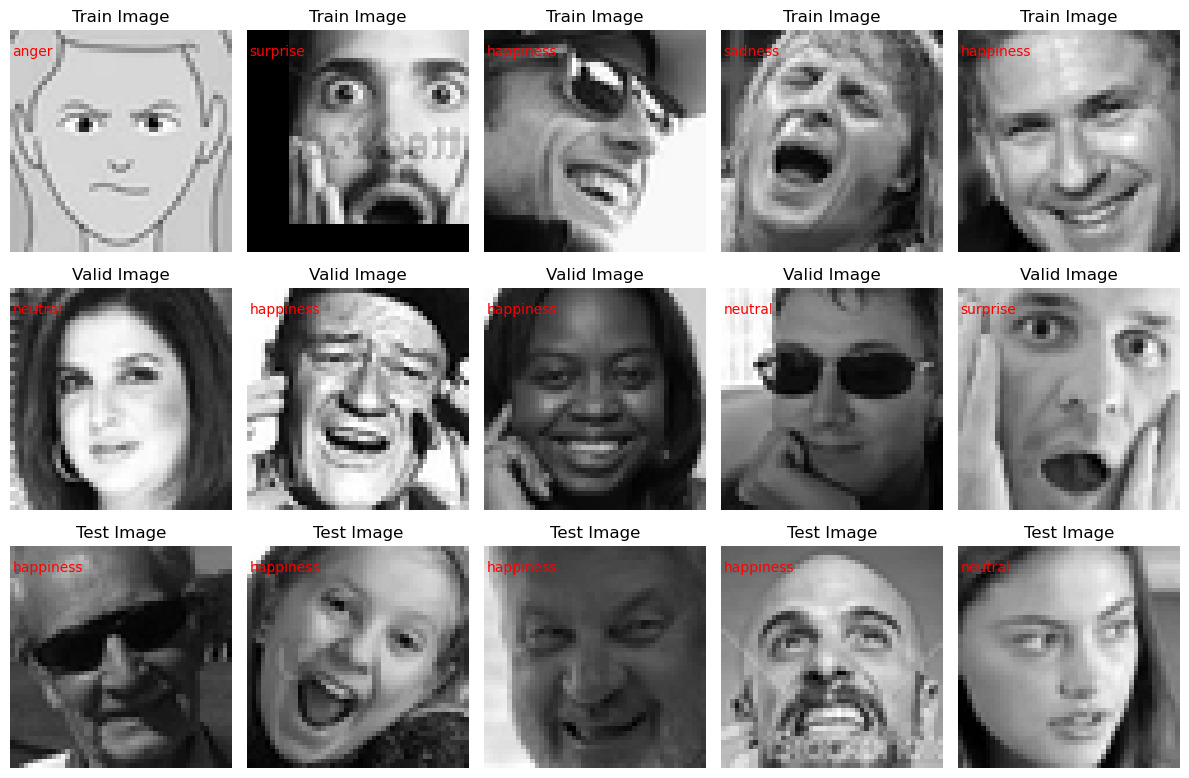

In [14]:
## Just for Debugging

# Define the emotion labels
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Randomly select and display images from the train set
train_indices = np.random.choice(len(train_dataset), size=5, replace=False)
train_images = [train_dataset[i]['image'] for i in train_indices]
train_labels = [train_dataset[i]['emotions'] for i in train_indices]

# Randomly select and display images from the validation set
valid_indices = np.random.choice(len(valid_dataset), size=5, replace=False)
valid_images = [valid_dataset[i]['image'] for i in valid_indices]
valid_labels = [valid_dataset[i]['emotions'] for i in valid_indices]

# Randomly select and display images from the test set
test_indices = np.random.choice(len(test_dataset), size=5, replace=False)
test_images = [test_dataset[i]['image'] for i in test_indices]
test_labels = [test_dataset[i]['emotions'] for i in test_indices]

# Display the images and labels
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

for i, (image, label) in enumerate(zip(train_images, train_labels)):
    axes[0, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Train Image')
    axes[0, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

for i, (image, label) in enumerate(zip(valid_images, valid_labels)):
    axes[1, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Valid Image')
    axes[1, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

for i, (image, label) in enumerate(zip(test_images, test_labels)):
    axes[2, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title('Test Image')
    axes[2, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

plt.tight_layout()
plt.show()


In [9]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Step 3: Load a pre-trained model and modify the classifier

In [49]:
def check_params(model):
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"The weights of {name} are frozen.")
        else:
            print(f"The weights of {name} are trainable.")

In [50]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Check if each parameter's requires_grad attribute is set to False

for param in model.parameters():
    param.requires_grad = False

check_params(model)
# print(model)

num_classes = 10
in_features = model.fc.in_features
# print("classes: ", num_classes)
# print("in feat: ", in_features)
# Modify the classifier
model.fc = nn.Linear(in_features, num_classes)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

print("=====================================")
check_params(model)
# model



The weights of conv1.weight are frozen.
The weights of bn1.weight are frozen.
The weights of bn1.bias are frozen.
The weights of layer1.0.conv1.weight are frozen.
The weights of layer1.0.bn1.weight are frozen.
The weights of layer1.0.bn1.bias are frozen.
The weights of layer1.0.conv2.weight are frozen.
The weights of layer1.0.bn2.weight are frozen.
The weights of layer1.0.bn2.bias are frozen.
The weights of layer1.1.conv1.weight are frozen.
The weights of layer1.1.bn1.weight are frozen.
The weights of layer1.1.bn1.bias are frozen.
The weights of layer1.1.conv2.weight are frozen.
The weights of layer1.1.bn2.weight are frozen.
The weights of layer1.1.bn2.bias are frozen.
The weights of layer2.0.conv1.weight are frozen.
The weights of layer2.0.bn1.weight are frozen.
The weights of layer2.0.bn1.bias are frozen.
The weights of layer2.0.conv2.weight are frozen.
The weights of layer2.0.bn2.weight are frozen.
The weights of layer2.0.bn2.bias are frozen.
The weights of layer2.0.downsample.0.wei

## Step 4: Define the loss function, optimizer, and training settings

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 5: Train the model

In [47]:
# Check if each parameter's requires_grad attribute is set to False
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"The weights of {name} are frozen.")
    else:
        print(f"The weights of {name} are trainable.")

The weights of conv1.weight are trainable.
The weights of bn1.weight are trainable.
The weights of bn1.bias are trainable.
The weights of layer1.0.conv1.weight are trainable.
The weights of layer1.0.bn1.weight are trainable.
The weights of layer1.0.bn1.bias are trainable.
The weights of layer1.0.conv2.weight are trainable.
The weights of layer1.0.bn2.weight are trainable.
The weights of layer1.0.bn2.bias are trainable.
The weights of layer1.1.conv1.weight are trainable.
The weights of layer1.1.bn1.weight are trainable.
The weights of layer1.1.bn1.bias are trainable.
The weights of layer1.1.conv2.weight are trainable.
The weights of layer1.1.bn2.weight are trainable.
The weights of layer1.1.bn2.bias are trainable.
The weights of layer2.0.conv1.weight are trainable.
The weights of layer2.0.bn1.weight are trainable.
The weights of layer2.0.bn1.bias are trainable.
The weights of layer2.0.conv2.weight are trainable.
The weights of layer2.0.bn2.weight are trainable.
The weights of layer2.0.b

In [22]:
# device = torch.device("cpu")
# model.to(device)
model.train()
for epoch in range(10):
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(train_loader, 0):
        labels = data['emotions'].to(device)  # Modify this line
        images = data['image'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # print(f'outouts before : {outputs}')
        loss = criterion(outputs, labels)
        print(f"loss before: {loss}")
        outputs = F.softmax(outputs)
        # print(f"outputs after softmax: {outputs}")
        # print sum of predictions
        
        # print(f"sum: {sum(outputs[0])}")
        # break;
        loss = criterion(outputs, labels)
        print(f"loss after: {loss}")
        
        # print("labels.data", labels.data)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        _, true = torch.max(labels, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == true)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.float() / len(train_dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} - acc: {epoch_acc * 100 :.2f}%')

# Save the trained model
# torch.save(model.state_dict(), 'pretrained_resnet18_10_epochs.pt')


loss before: 48.580528259277344
loss after: 19.771602630615234
loss before: 39.26675033569336
loss after: 19.102142333984375
loss before: 53.95554733276367
loss after: 20.127498626708984
loss before: 52.60693359375
loss after: 19.867578506469727


/var/folders/bv/p2h40cmn08db49qkwp05xlbr0000gn/T/ipykernel_93815/2503894033.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


loss before: 52.025230407714844
loss after: 19.64617156982422
loss before: 48.65380859375
loss after: 19.31875991821289
loss before: 65.7448501586914
loss after: 20.315017700195312
loss before: 60.69387435913086
loss after: 20.134380340576172
loss before: 48.23578643798828
loss after: 19.592559814453125
loss before: 66.66708374023438
loss after: 20.410037994384766
loss before: 46.30785369873047
loss after: 19.672924041748047
loss before: 46.60120391845703
loss after: 18.761144638061523
loss before: 81.9646224975586
loss after: 21.799110412597656
loss before: 42.41340637207031
loss after: 19.34994125366211
loss before: 55.173919677734375
loss after: 20.207355499267578
loss before: 54.147499084472656
loss after: 19.69852638244629
loss before: 49.479286193847656
loss after: 19.6064453125
loss before: 51.94847869873047
loss after: 19.807086944580078
loss before: 63.62247848510742
loss after: 20.715484619140625
loss before: 42.93523406982422
loss after: 19.73910140991211
loss before: 54.017

KeyboardInterrupt: 

In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_correct = 0
total_samples = 0
model.to(device)
with torch.inference_mode():
    for data in valid_loader:
        labels = data['emotions'].to(device)
        images = data['image'].to(device)
        
        outputs = model(images)
        val_loss += criterion(outputs, labels).item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        
        val_correct += torch.eq(predicted, labels).sum().item()
        total_samples += images.size(0)
    
val_loss /= total_samples
val_accuracy = val_correct / total_samples

print(f'Validation Loss: {val_loss:.4f} | Accuracy: {val_accuracy * 100:.2f}%')


In [ ]:
# dictionary for classess names in FERplus dataset
classes = {
    0: 'Neutral',
    1: 'Happinnes',
    2: 'Surprise',
    3: 'Sadness',
    4: 'Anger',
    5: 'Disgust',
    6: 'Fear',
    7: 'Contempt',
    8: 'Unknown',
    9: 'NF'
}

In [ ]:
idx = 1000

np_img = test_dataset[idx]['image']
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.show()
plt.close()
print (f"the original label was {classes[test_dataset[idx]['emotions'].argmax(0).item()]}\n")


In [ ]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=10).to(device)


In [ ]:
# test model on the test data set
import torch.nn.functional as F
import torch
def test_model(model, test_loader, dataset):
    model.to('cpu')
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracy = []
    wrong = 0
    with torch.inference_mode():
        for i, data in enumerate(test_loader):
            labels = data['emotions']
            inputs = data['image']
            output = model(inputs)
            # print("out: ", output.shape)
            # print("labels: ", labels.shape)
            # print(labels.shape)
            # print(f"test loader length:  {len(test_loader)}")
            # show the first 10 images and their truth labels and their predictions
            if i < len(test_loader):
                for j in range(len(inputs)):
                    # if classes[labels[j].argmax(0).item()] != classes[output[j].argmax(0).item()] :
                    #     wrong +=1
                    
                    
                    file_name = "mymodel.txt"
                    output_file = open(file_name, "a")
                    prediction = classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]
                    
                    output_file.write(f"image: {i * batch_size + j} was {prediction}\n")
                    output_file.write(f"predicted label was: {classes[output[j].argmax(0).item()]} and the original label was {classes[labels[j].argmax(0).item()]}\n")
                    output_file.write("="*50)
                    output_file.write("\n")
                    # if j == 10:
                    #     print("one example:")
                    #     np_img = test_dataset[i * batch_size + j]['image']
                    #     plt.imshow(np.transpose(np_img, (1, 2, 0)))
                    #     plt.show()
                    #     plt.close()
                    #     print('-'*50)
                        
                    # print(labels[i].argmax().item())
                    # if classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]:
                    #     print("hoppppaaaaaaaaaa")
                    #     print('image:', i * batch_size + j)
                        
                    #     print('truth:', classes[labels[j].argmax(0).item()])
                    #     print('prediction:', classes[output[j].argmax(0).item()])
                    #     print('='*50)
                    # plt.close('all')    
            output_file.close()
            # measure accuracy
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            # torchmetrics_accuracy(predicted, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_accuracy.append(torchmetrics_accuracy(predicted, labels))
        # print total accuracy
        print('Accuracy of the network on the test images: %d %%' % (
            100 * correct / total))
        print(f"correct: {correct}, total: {total}")
        print(test_accuracy)
test_model(model, test_loader, test_dataset)

In [ ]:
model.load_state_dict(torch.load('./pretrained_resnet18.pt'))

In [ ]:
model.to(device)
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
total_samples = 0

with torch.no_grad():
    for data in test_loader:
        labels = data['emotions'].to(device)
        images = data['image'].to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels, 1)
        
        test_loss += criterion(outputs, labels).item() 
        test_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
test_loss /= total_samples
test_accuracy = test_correct / total_samples

print(f'Test Loss: {test_loss:.4f} | Accuracy: {test_accuracy * 100:.2f}%')


1- change first layer 
2- documteation bta3 tranfer learning and resnet 
3- loss fix 
4- 